В тетрадке приведены методы определения тональности всего отзыва. Произведена лемматизация, векторизация (sbert (векторизация по отзывам целиком), word2vec, fasttext, адаграм). Классификация была произведена с помощью XGBoost, Logistic Regression, Random Forest, K-nearest neighbors. Классификация с помощью берта (мультилингвальный и русский) в другой тетрадке.

In [18]:
!pip install git+https://github.com/lopuhin/python-adagram.git -q

  Preparing metadata (setup.py) ... done


In [19]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec
import adagram

Скачиваем токенайзер и модель сберта

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")

Скачиваем модель адаграма

In [21]:
!curl "https://s3.amazonaws.com/kostia.lopuhin/all.a010.p10.d300.w5.m100.nonorm.slim.joblib" > /content/drive/MyDrive/all.a010.p10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1394M  100 1394M    0     0  42.0M      0  0:00:33  0:00:33 --:--:-- 29.9M


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Открываем табличку, в которой уже все есть (о чудо, делается табличка в другом ноутбуке).

In [22]:
merged_df = pd.read_csv('/content/drive/MyDrive/merged_df.csv')

In [8]:
'''

Добавляем в табличку список лемматизации
lemmatized_by_word = []
for i in merged_df['Lemmatized Review'].to_list():
   i = i.split(' ')
   lemmatized_by_word.append(i)
merged_df['Lemmatized by word'] = lemmatized_by_word
'''

In [9]:
merged_df

,Unnamed: 0,ID,Food,Interior,Price,Service,Whole,Lemmatized Review,Review,Lemmatized by word
0,0,280,0,2,4,0,0,привезти в этот ресторан друг - у он там быть ...,Привез в этот ресторан друг - у него там была ...,"[привезти, в, этот, ресторан, друг, -, у, он, ..."
1,1,343,0,0,4,2,0,отмечать свадьба в это ресторан ! в целое всё ...,Отмечали свадьбу в этом ресторане! В целом все...,"[отмечать, свадьба, в, это, ресторан, !, в, це..."
2,2,719,2,2,4,0,0,прислать небольшой компания отметить день рожд...,Пришли небольшой компанией отметить день рожде...,"[прислать, небольшой, компания, отметить, день..."
3,3,785,2,0,1,0,2,добрый день ! отмечать свадьба 18 август . в о...,Добрый день! Отмечали свадьбу 18 августа. В об...,"[добрый, день, !, отмечать, свадьба, 18, авгус..."
4,4,797,3,4,4,1,2,"быть в ресторан 2 раз . один раз день , всё по...","Были в ресторане 2 раза. Один раз днем, все по...","[быть, в, ресторан, 2, раз, ., один, раз, день..."
...,...,...,...,...,...,...,...,...,...,...
279,279,37975,0,0,0,0,0,праздновать свадьба в это ресторан 7 август 20...,Праздновали свадьбу в этом ресторане 7 августа...,"[праздновать, свадьба, в, это, ресторан, 7, ав..."
280,280,38077,0,2,4,0,0,первый свидание с молодой человек решить прове...,Первое свидание с молодым человеком решили про...,"[первый, свидание, с, молодой, человек, решить..."
281,281,38299,0,0,4,0,0,"случайно увидеть акция на сайт купон , решить ...","Случайно увидели акцию на сайте купонов, решил...","[случайно, увидеть, акция, на, сайт, купон, ,,..."
282,282,38772,0,0,4,0,0,наш семья в восторг от данный ресторан ! ! ! ж...,Наша семья в восторге от данного ресторана!!! ...,"[наш, семья, в, восторг, от, данный, ресторан,..."


Делаем эмбеддинги сберта

In [6]:

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def compute_token_embeddings(tokenizer, model):
  encoded_input = tokenizer(merged_df['Lemmatized Review'].to_list(), padding=True, truncation=True, max_length=24, return_tensors='pt')

  with torch.no_grad():
      model_output = model(**encoded_input)


  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
  return sentence_embeddings


tokenizer_config.json:   0%|          | 0.00/323 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [ ]:
sentence_embeddings = compute_token_embeddings(tokenizer, model)

Делаем эмбеддинги w2v

In [11]:
def w2v_vocab():
  w2v_model = Word2Vec(
      min_count=5,
      window=3,
      vector_size=300,
      negative=10,
      alpha=0.03,
      min_alpha=0.0007,
      sample=6e-5,
      sg=1)
  w2v_model.build_vocab(merged_df['Lemmatized by word'].to_list())
  w2v_vocabulary = w2v_model.wv.key_to_index
  w2v_model.train(merged_df['Lemmatized by word'].to_list(), total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
  return w2v_model, w2v_vocabulary

In [12]:
w2v_model, w2v_vocabulary = w2v_vocab()
merged_df['w2v_vectors'] = merged_df.apply(lambda row: [w2v_model.wv.get_vector(word) if word in w2v_vocabulary else np.zeros(300) for word in row['Lemmatized by word']], axis=1)

Делаем w2v подходящим для обучения

In [14]:
def average_pooling(embeddings):
    return np.mean(np.array(embeddings), axis=0)

flattened_embeddings = []
for i in merged_df['w2v_vectors'].to_list():
  flattened_embedding = average_pooling(i)
  flattened_embeddings.append(flattened_embedding)

Делаем эмбеддинги Adamgram

In [24]:
vm = adagram.VectorModel.load('/content/drive/MyDrive/all.a010.p10')

In [25]:
def get_words_in_context(words):
  neighbours = []
  for i in range(len(words)):
    if i - 3 < 0:
      words_after = words[i + 1:i + 4]
      words_before = words[0:i]
      ws = words_before + words_after
      lst = list([words[i], ws])
      neighbours.append(lst)

    else:
      words_after = words[i + 1:i + 4]
      words_before = words[i - 3:i]
      ws = words_before + words_after
      lst = list([words[i], ws])
      neighbours.append(lst)

  return neighbours

In [26]:
def get_embedding_adagram(text):
    word2context = get_words_in_context(text)
    vectors = np.zeros((len(word2context), 300))
    for i, (word, context) in enumerate(word2context):
        try:
            v = vm.sense_vector(word, vm.disambiguate(word, text).argmax())
            vectors[i] = v
        except (KeyError, ValueError):
            continue
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((300))
    return vector

In [28]:
X_text = np.zeros((len(merged_df['Lemmatized Review']), 300))

for i, text in enumerate(merged_df['Lemmatized Review']):
    X_text[i] = get_embedding_adagram(text)

/usr/local/lib/python3.10/dist-packages/adagram/model.py:171: RuntimeWarning: divide by zero encountered in log
  z = np.log(z)


Делаем xgboost для сберта и ворд2века

In [9]:
def xgboost(embeddings):
  labels = ['Food',	'Interior',	'Price',	'Service',	'Whole']
  predictions = []
  scores = []
  for label in labels:
    X_train, X_test, y_train, y_test = train_test_split(embeddings, merged_df[label], test_size=.2, random_state=42)
    bst = XGBClassifier(objective="multi:softprob", random_state=42)
    bst.fit(X_train, y_train)
    preds = bst.predict(X_test)
    acc_score = accuracy_score(y_test, preds)
    predictions.append(preds)
    scores.append(acc_score)
  return predictions, scores

In [19]:
w2v_preds_xgboost, w2v_score_xgboost = xgboost(flattened_embeddings)
print(w2v_score_xgboost)

[0.7719298245614035, 0.8070175438596491, 0.5614035087719298, 0.7719298245614035, 0.8070175438596491]


In [22]:
print(sum(w2v_score_xgboost)/len(w2v_score_xgboost))

0.743859649122807


In [12]:
sbert_preds_xgboost, sbert_score_xgboost = xgboost(sentence_embeddings)

print(sbert_score_xgboost)

[0.7543859649122807, 0.6666666666666666, 0.543859649122807, 0.6491228070175439, 0.7368421052631579]


In [13]:
print(sum(sbert_score_xgboost)/len(sbert_score_xgboost))

0.6701754385964912


Вывод: у более простого, казалось бы, ворд2века, результат лучше по всем категориям и оверолл тоже сильно

Делаем рандомфорест

In [20]:
def randomforest(embeddings):
  labels = ['Food',	'Interior',	'Price',	'Service',	'Whole']
  predictions = []
  scores = []
  for label in labels:
    X_train, X_test, y_train, y_test = train_test_split(embeddings, merged_df[label], test_size=.2)
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(X_train, y_train)
    pred_rf = rfc.predict(X_test)
    acc_score = accuracy_score(y_test, pred_rf)
    predictions.append(pred_rf)
    scores.append(acc_score)
  return predictions, scores


In [21]:
w2v_preds_rf, w2v_score_rf = randomforest(flattened_embeddings)
print(w2v_score_rf)

[0.6842105263157895, 0.631578947368421, 0.5263157894736842, 0.6842105263157895, 0.7192982456140351]


In [23]:
print(sum(w2v_score_rf)/len(w2v_score_rf))

0.6491228070175439


In [24]:
sbert_preds_rf, sbert_score_rf = randomforest(sentence_embeddings)
print(sbert_score_rf)

[0.6842105263157895, 0.7192982456140351, 0.631578947368421, 0.7017543859649122, 0.6842105263157895]


In [25]:
print(sum(sbert_score_rf)/len(sbert_score_rf))

0.6842105263157895


А теперь у сберта лучше! Но не сильно

В планах было досчитать для логрега и к нейборс, но не успелось

In [29]:
def logreg(embeddings):
  X_train, X_test, y_train, y_test = train_test_split(embeddings, reviews_df['Label'], test_size=.2)
  clf = LogisticRegression(random_state=0).fit(X_train, y_train)
  pred_clf = clf.predict(X_test)
  acc_score = accuracy_score(y_test, pred_clf)
  return pred_clf, acc_score

In [30]:
sbert_preds_lr, sbert_score_lr = logreg(sentence_embeddings)
print(sbert_score_lr)

NameError: ignored

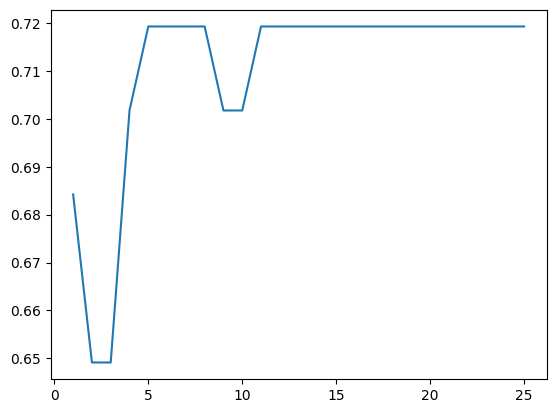

In [63]:
def k_neighboor_plot(embeddings):
  X_train, X_test, y_train, y_test = train_test_split(embeddings, reviews_df['Label'], test_size=.2)
  k_range = list(range(1, 26))
  scores = []
  for i in k_range:
      knn = KNeighborsClassifier(n_neighbors=i)
      knn.fit(X_train, y_train)
      y_pred = knn.predict(X_test)
      scores.append(accuracy_score(y_test, y_pred))
  plt.plot(k_range, scores)
  plt.show()

In [70]:
def k_neighboor(embeddings):
  X_train, X_test, y_train, y_test = train_test_split(embeddings, reviews_df['Label'], test_size=.2)
  k_nb = KNeighborsClassifier(n_neighbors=5)
  k_nb.fit(X_train, y_train)
  pred_k = k_nb.predict(X_test)
  acc_score = accuracy_score(y_test, pred_k)
  return pred_k, acc_score

0.7192982456140351